## Code Structure
1. Load & Parse Emails (raw content → DataFrame)
2. Light Cleaning (remove tabs, decode content, clean whitespace)
3. Exploratory Data Analysis (EDA)
4. Named Entity Recognition (NER) on raw/lightly cleaned text
5. Full Text Preprocessing (for modeling)
     tokenization, lowercasing, stopwords, optional stemming
6. Feature Extraction (TF-IDF, n-grams, embeddings)
7. NLP Models (task classifier, topic detection, etc.)
8. Output: to-do list, timeline, graph data, structured output

# Load Data

In [1]:
import tarfile
import email
import pandas as pd
from email import policy
from email.parser import BytesParser

In [2]:
archive_path = "enron_mail_20150507.tar.gz"
emails = []
count = 0

# Parse plain text from email object
def get_text_from_email(msg):
    parts = []
    if msg.is_multipart():
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                try:
                    parts.append(part.get_payload(decode=True).decode('latin1'))
                except:
                    pass
    else:
        try:
            parts.append(msg.get_payload(decode=True).decode('latin1'))
        except:
            pass
    return ''.join(parts)

In [3]:
with tarfile.open(archive_path, "r:gz") as tar:
    for member in tar:
        if member.isfile() and not member.name.endswith('/'):
            try:
                f = tar.extractfile(member)
                raw_email = f.read()
                msg = email.message_from_bytes(raw_email)

                email_data = {
                    "file": member.name,
                    "Message-ID": msg.get("Message-ID"),
                    "Date": msg.get("Date"),
                    "From": msg.get("From"),
                    "To": msg.get("To"),
                    "Subject": msg.get("Subject"),
                    "Mime-Version": msg.get("Mime-Version"),
                    "Content-Type": msg.get("Content-Type"),
                    "Content-Transfer-Encoding": msg.get("Content-Transfer-Encoding"),
                    "X-From": msg.get("X-From"),
                    "X-To": msg.get("X-To"),
                    "X-cc": msg.get("X-cc"),
                    "X-bcc": msg.get("X-bcc"),
                    "X-Folder": msg.get("X-Folder"),
                    "X-Origin": msg.get("X-Origin"),
                    "X-FileName": msg.get("X-FileName"),
                    "content": get_text_from_email(msg)
                }

                emails.append(email_data)
                count += 1

            except Exception:
                continue

In [4]:
# Create DataFrame
df_emails = pd.DataFrame(emails)

print(df_emails.shape)
df_emails.head()

(517401, 17)


,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content
0,maildir/blair-l/personnel___promotions/1.,<8012132.1075853083164.JavaMail.evans@thyme>,"Fri, 14 Sep 2001 14:05:43 -0700 (PDT)",fran.fagan@enron.com,lynn.blair@enron.com,FW: Promotions and Transfers- Gas Logistics,1.0,text/plain; charset=us-ascii,7bit,"Fagan, Fran </O=ENRON/OU=NA/CN=RECIPIENTS/CN=F...","Blair, Lynn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=L...",,,"\LBLAIR (Non-Privileged)\Blair, Lynn\Personnel...",Blair-L,LBLAIR (Non-Privileged).pst,\n\n\n\nName\t\t\tNew Title\t\t\t\tEffective D...
1,maildir/blair-l/meetings___nng_customer_mtg/8.,<15791711.1075853024135.JavaMail.evans@thyme>,"Mon, 10 Sep 2001 10:33:15 -0700 (PDT)",maggie.matheson@enron.com,"randy.bryan@enron.com, robert.benningfield@enr...",Customer Training,1.0,text/plain; charset=us-ascii,7bit,"Matheson, Maggie </O=ENRON/OU=NA/CN=RECIPIENTS...","Bryan, Randy </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Holmes, Bradley </O=ENRON/OU=NA/CN=RECIPIENTS/...",,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,\n\nFirst I want to thank you for all of your ...
2,maildir/blair-l/meetings___nng_customer_mtg/16.,<15061964.1075853024388.JavaMail.evans@thyme>,"Mon, 20 Aug 2001 12:34:19 -0700 (PDT)",sharon.brown@enron.com,"e..anderson@enron.com, vicki.berg@enron.com, l...",Winter Ops - KC Hotel Information,1.0,text/plain; charset=us-ascii,7bit,"Brown, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Anderson, Gary E. </O=ENRON/OU=NA/CN=RECIPIENT...","Armstrong, Julie </O=ENRON/OU=NA/CN=RECIPIENTS...",,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,\t\nBelow listed is the contact information fo...
3,maildir/blair-l/meetings___nng_customer_mtg/13.,<4937308.1075853024299.JavaMail.evans@thyme>,"Thu, 5 Jul 2001 08:35:29 -0700 (PDT)",lynn.blair@enron.com,sharon.brown@enron.com,Winter Ops Meeting,1.0,text/plain; charset=us-ascii,7bit,"Blair, Lynn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=L...","Brown, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Blair, Lynn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=L...",,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,"\t\t\n\tSharon, could add the following compan..."
4,maildir/blair-l/meetings___nng_customer_mtg/14.,<1237601.1075853024323.JavaMail.evans@thyme>,"Thu, 26 Jul 2001 08:16:14 -0700 (PDT)",sharon.brown@enron.com,"larry.steward@enron.com, toby.kuehl@enron.com,...",Draft - Winter Ops Agenda,1.0,text/plain; charset=us-ascii,7bit,"Brown, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Steward, Larry </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Winters, Ricki </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,\nAttached is a draft of the agenda for the Wi...


# Clean Data

In [5]:
# Step 1: Clean timezone labels
df_emails['clean_date'] = df_emails['Date'].str.replace(r'\s+\(.*\)', '', regex=True)

# Step 2: Parse datetime safely & force conversion
df_emails['Date'] = pd.to_datetime(df_emails['clean_date'], errors='coerce', utc=True)

# Drop noisy columns if needed
df_emails = df_emails.drop(columns=['Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'clean_date'])

df_emails.head()

,file,Message-ID,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content
0,maildir/blair-l/personnel___promotions/1.,<8012132.1075853083164.JavaMail.evans@thyme>,2001-09-14 21:05:43+00:00,fran.fagan@enron.com,lynn.blair@enron.com,FW: Promotions and Transfers- Gas Logistics,"Fagan, Fran </O=ENRON/OU=NA/CN=RECIPIENTS/CN=F...","Blair, Lynn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=L...",,,"\LBLAIR (Non-Privileged)\Blair, Lynn\Personnel...",Blair-L,LBLAIR (Non-Privileged).pst,\n\n\n\nName\t\t\tNew Title\t\t\t\tEffective D...
1,maildir/blair-l/meetings___nng_customer_mtg/8.,<15791711.1075853024135.JavaMail.evans@thyme>,2001-09-10 17:33:15+00:00,maggie.matheson@enron.com,"randy.bryan@enron.com, robert.benningfield@enr...",Customer Training,"Matheson, Maggie </O=ENRON/OU=NA/CN=RECIPIENTS...","Bryan, Randy </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Holmes, Bradley </O=ENRON/OU=NA/CN=RECIPIENTS/...",,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,\n\nFirst I want to thank you for all of your ...
2,maildir/blair-l/meetings___nng_customer_mtg/16.,<15061964.1075853024388.JavaMail.evans@thyme>,2001-08-20 19:34:19+00:00,sharon.brown@enron.com,"e..anderson@enron.com, vicki.berg@enron.com, l...",Winter Ops - KC Hotel Information,"Brown, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Anderson, Gary E. </O=ENRON/OU=NA/CN=RECIPIENT...","Armstrong, Julie </O=ENRON/OU=NA/CN=RECIPIENTS...",,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,\t\nBelow listed is the contact information fo...
3,maildir/blair-l/meetings___nng_customer_mtg/13.,<4937308.1075853024299.JavaMail.evans@thyme>,2001-07-05 15:35:29+00:00,lynn.blair@enron.com,sharon.brown@enron.com,Winter Ops Meeting,"Blair, Lynn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=L...","Brown, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Blair, Lynn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=L...",,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,"\t\t\n\tSharon, could add the following compan..."
4,maildir/blair-l/meetings___nng_customer_mtg/14.,<1237601.1075853024323.JavaMail.evans@thyme>,2001-07-26 15:16:14+00:00,sharon.brown@enron.com,"larry.steward@enron.com, toby.kuehl@enron.com,...",Draft - Winter Ops Agenda,"Brown, Sharon </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Steward, Larry </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Winters, Ricki </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,\nAttached is a draft of the agenda for the Wi...


In [6]:
import re

def extract_display_name(x):
    if not isinstance(x, str):
        return ""
    match = re.match(r"^([^<@]+)", x)
    if match:
        name = match.group(1).strip()
        # If it's "Last, First", flip it
        if ',' in name:
            parts = [p.strip() for p in name.split(',')]
            if len(parts) == 2:
                return f"{parts[1]} {parts[0]}"
        return name
    return x.strip()

In [7]:
df_emails['Name-From'] = df_emails['X-From'].apply(extract_display_name)
df_emails['Name-To'] = df_emails['X-To'].apply(extract_display_name)
df_emails['Name-cc'] = df_emails['X-cc'].apply(extract_display_name)
df_emails['Name-bcc'] = df_emails['X-bcc'].apply(extract_display_name)

In [8]:
import re

def clean_email_body(text):
    if not isinstance(text, str):
        return ""
    text = text.replace('\n', ' ')  # remove line breaks
    text = text.replace('\t', ' ')  # remove tabs
    text = re.sub(r'\s+', ' ', text)  # normalize extra whitespace
    text = re.sub(r'[^a-zA-Z0-9.,!?$%:;/@#\'\"()\- ]', '', text)  # optional: remove weird characters
    return text.strip()

df_emails['content'] = df_emails['content'].apply(clean_email_body)

# Drop noisy columns if needed
df_emails = df_emails.drop(columns=['X-From', 'X-To', 'X-cc', 'X-bcc'])

df_emails.head()

,file,Message-ID,Date,From,To,Subject,X-Folder,X-Origin,X-FileName,content,Name-From,Name-To,Name-cc,Name-bcc
0,maildir/blair-l/personnel___promotions/1.,<8012132.1075853083164.JavaMail.evans@thyme>,2001-09-14 21:05:43+00:00,fran.fagan@enron.com,lynn.blair@enron.com,FW: Promotions and Transfers- Gas Logistics,"\LBLAIR (Non-Privileged)\Blair, Lynn\Personnel...",Blair-L,LBLAIR (Non-Privileged).pst,Name New Title Effective Date Mid Year promoti...,Fran Fagan,Lynn Blair,,
1,maildir/blair-l/meetings___nng_customer_mtg/8.,<15791711.1075853024135.JavaMail.evans@thyme>,2001-09-10 17:33:15+00:00,maggie.matheson@enron.com,"randy.bryan@enron.com, robert.benningfield@enr...",Customer Training,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,First I want to thank you for all of your help...,Maggie Matheson,Randy Bryan,Bradley Holmes,
2,maildir/blair-l/meetings___nng_customer_mtg/16.,<15061964.1075853024388.JavaMail.evans@thyme>,2001-08-20 19:34:19+00:00,sharon.brown@enron.com,"e..anderson@enron.com, vicki.berg@enron.com, l...",Winter Ops - KC Hotel Information,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,Below listed is the contact information for Th...,Sharon Brown,Gary E. Anderson,Julie Armstrong,
3,maildir/blair-l/meetings___nng_customer_mtg/13.,<4937308.1075853024299.JavaMail.evans@thyme>,2001-07-05 15:35:29+00:00,lynn.blair@enron.com,sharon.brown@enron.com,Winter Ops Meeting,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,"Sharon, could add the following company/person...",Lynn Blair,Sharon Brown,Lynn Blair,
4,maildir/blair-l/meetings___nng_customer_mtg/14.,<1237601.1075853024323.JavaMail.evans@thyme>,2001-07-26 15:16:14+00:00,sharon.brown@enron.com,"larry.steward@enron.com, toby.kuehl@enron.com,...",Draft - Winter Ops Agenda,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings ...",Blair-L,LBLAIR (Non-Privileged).pst,Attached is a draft of the agenda for the Wint...,Sharon Brown,Larry Steward,Ricki Winters,


In [41]:
df_emails_clean = df_emails[
    df_emails['From'].notnull() &
    df_emails['To'].notnull() &
    df_emails['From'].str.contains('@enron.com', na=False) &
    df_emails['To'].str.contains('@enron.com', na=False)
]

In [42]:
df_target = df_emails_clean[
    df_emails_clean['X-Folder'].str.contains("sent", case=False, na=False) &
    df_emails_clean['X-Folder'].str.contains("legal|risk", case=False, na=False)
]

In [43]:
df_target

,file,Message-ID,Date,From,To,Subject,X-Folder,X-Origin,X-FileName,content,Name-From,Name-To,Name-cc,Name-bcc,month,year,custom_clean_content,custom_clean_subject
70482,maildir/taylor-m/sent_items/318.,<19099846.1075858608851.JavaMail.evans@thyme>,2001-07-31 19:45:55,legal <.taylor@enron.com>,joel.ephross@enron.com,RE: Enron/Barclays Global Markets Inventory Fi...,"\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",Taylor-M,MTAYLO1 (Non-Privileged).pst,Joel -- I've taken a quick look at these and t...,Mark E (Legal) Taylor,Joel Ephross,,,2001-07,2001,joel taken quick look think really physical tr...,global markets inventory financing
70483,maildir/taylor-m/sent_items/354.,<5056854.1075858609830.JavaMail.evans@thyme>,2001-08-13 22:08:27,legal <.taylor@enron.com>,"mary.cook@enron.com, n..gray@enron.com, mark.g...",Project Lists,"\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",Taylor-M,MTAYLO1 (Non-Privileged).pst,If you have not sent me a current project list...,Mark E (Legal) Taylor,Mary Cook,,,2001-08,2001,sent current project list within last week ple...,project lists
70484,maildir/taylor-m/sent_items/169.,<5029371.1075858604959.JavaMail.evans@thyme>,2001-10-26 20:06:00,legal <.taylor@enron.com>,"sara.shackleton@enron.com, brent.hendry@enron.com",FW: Cost Allocations,"\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",Taylor-M,MTAYLO1 (Non-Privileged).pst,Please see me before responding to Alan. Thank...,Mark E (Legal) Taylor,Sara Shackleton,,,2001-10,2001,please see responding alan thanks mark message...,cost allocations
70485,maildir/taylor-m/sent_items/388.,<17195914.1075858610602.JavaMail.evans@thyme>,2001-08-23 14:08:11,legal <.taylor@enron.com>,marie.heard@enron.com,FW: American Airlines,"\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",Taylor-M,MTAYLO1 (Non-Privileged).pst,"-----Original Message----- From: Friedman, Ric...",Mark E (Legal) Taylor,Marie Heard,,,2001-08,2001,message friedman richard sent thursday august ...,american airlines
70487,maildir/taylor-m/sent_items/246.,<1577022.1075858607192.JavaMail.evans@thyme>,2001-07-09 15:40:35,legal <.taylor@enron.com>,janette.elbertson@enron.com,"FW: EB38, Updated Floor Plan","\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",Taylor-M,MTAYLO1 (Non-Privileged).pst,"-----Original Message----- From: Keiser, Holly...",Mark E (Legal) Taylor,Janette Elbertson,,,2001-07,2001,message keiser holly sent monday july taylor m...,updated floor plan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71021,maildir/taylor-m/sent_items/306.,<2929472.1075858608572.JavaMail.evans@thyme>,2001-07-26 15:51:48,legal <.taylor@enron.com>,jake.staffel@enron.com,EnronOnline Customer Lists,"\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",Taylor-M,MTAYLO1 (Non-Privileged).pst,Our agreements with EnronOnline customers proh...,Mark E (Legal) Taylor,Jake Staffel,Tana Jones,,2001-07,2001,agreement enrononline customer prohibit sharin...,enrononline customer lists
71024,maildir/taylor-m/sent_items/162.,<3123937.1075858604800.JavaMail.evans@thyme>,2001-10-23 19:16:12,legal <.taylor@enron.com>,frank.sayre@enron.com,RE: Trades as ENA,"\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",Taylor-M,MTAYLO1 (Non-Privileged).pst,I agree with Susan that for non-EOL trades con...,Mark E (Legal) Taylor,Frank Sayre,,,2001-10,2001,agree susan trade concluded trader nyc houston...,trades ena
71025,maildir/taylor-m/sent_items/122.,<22024760.1075858603875.JavaMail.evans@thyme>,2001-10-03 14:27:42,legal <.taylor@enron.com>,holly.keiser@enron.com,FW: Calling card number,"\MTAYLO1 (Non-Privileged)\Taylor, Mark E (Lega...",Taylor-M,MTAYLO1 (Non-Privileged).pst,I hope it was ok to respond to this - because ...,Mark E (Legal) Taylor,Holly Keiser,,,2001-10,2001,hope respond message magee tycie sent tuesday ...,calling card number
71027,maildir/taylor-m/sent_items/411.,<32602190.1075859396486.JavaMail.evans@thyme>,2001-12-11 16:31:19,legal <.taylor@enron.com>,joe.henry@enron.com,UBS CA,"\Mark_Tay

# EDA

### Email volume over time

In [9]:
df_emails = df_emails[df_emails['X-Folder'].str.contains("Important|Sent", case=False, na=False)]

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 3: Drop invalid datetimes
df_emails = df_emails[df_emails['Date'].notnull()].copy()

# Step 4: Convert from timezone-aware to naive datetime (optional, but safest)
df_emails['Date'] = df_emails['Date'].dt.tz_localize(None)

# Step 5: Create 'month' column
df_emails['month'] = df_emails['Date'].dt.to_period('M')

# Step 5: Count emails per month
monthly_counts = df_emails['month'].value_counts().sort_index()

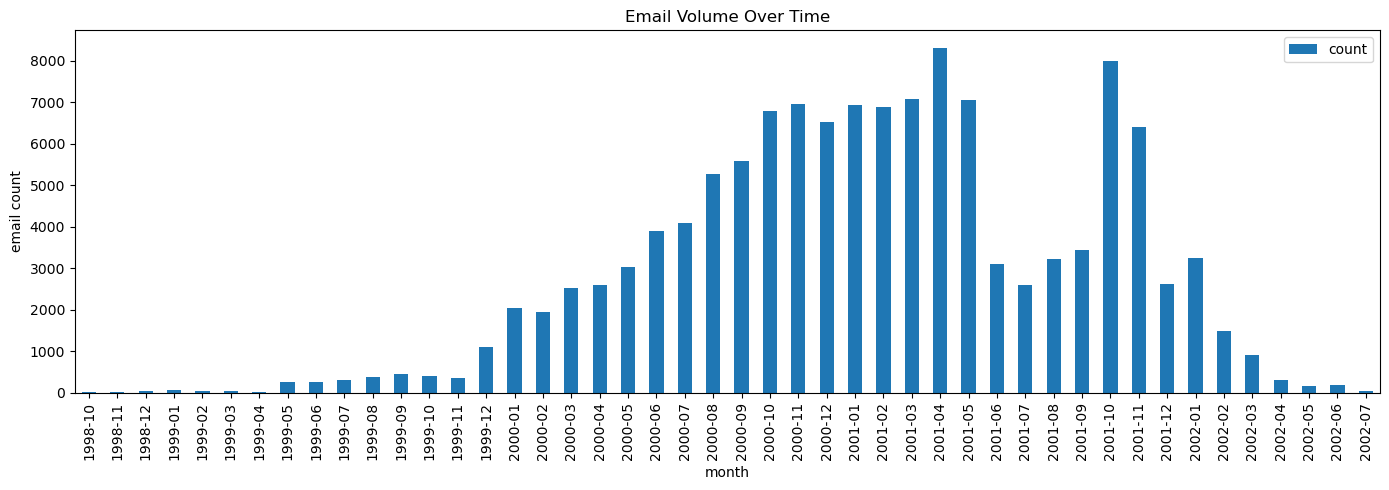

In [11]:
plt.figure(figsize=(14, 5))
monthly_counts.plot(kind='bar')

plt.title("Email Volume Over Time")
plt.xlabel("month")
plt.ylabel("email count")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
df_emails[['Date', 'From', 'To', 'Subject', 'content']].sort_values(by='Date', ascending=False).head(10)

,Date,From,To,Subject,content
273414,2002-07-12 08:31:00,mark.fisher@enron.com,tom.nemila@enron.com,WR613 Pitch System performance,"Tom, Here is the report I prepared on the meth..."
273174,2002-07-12 08:31:00,mark.fisher@enron.com,tom.nemila@enron.com,WR613 Pitch System performance,"Tom, Here is the report I prepared on the meth..."
273181,2002-07-12 08:21:00,mark.fisher@enron.com,tom.nemila@enron.com,WR627 Fault Paretos (May 2002),"Tom, Here are the fault paretos of fault count..."
273413,2002-07-12 08:21:00,mark.fisher@enron.com,tom.nemila@enron.com,WR627 Fault Paretos (May 2002),"Tom, Here are the fault paretos of fault count..."
273178,2002-07-11 16:22:00,mark.fisher@enron.com,jeff.duff@enron.com,Desert Sky Curtailment,"Jeff, Mar - May 2002 have been recalculated an..."
273407,2002-07-11 16:22:00,mark.fisher@enron.com,jeff.duff@enron.com,Desert Sky Curtailment,"Jeff, Mar - May 2002 have been recalculated an..."
273408,2002-07-11 15:12:00,mark.fisher@enron.com,tim.derrick@enron.com,Fluvanna and Trew Ranch reports,"Tim, In Oct 2001 I produced the attached repor..."
273189,2002-07-11 15:12:00,mark.fisher@enron.com,tim.derrick@enron.com,Fluvanna and Trew Ranch reports,"Tim, In Oct 2001 I produced the attached repor..."
273175,2002-07-11 14:24:00,mark.fisher@enron.com,julie.johnson@enron.com,Work Request,Fault Pareto Work Request From Tom Nemila
273412,2002-07-11 14:24:00,mark.fisher@enron.com,julie.johnson@enron.com,Work Request,Fault Pareto Work Request From Tom Nemila


Starting 2000, the volume of emails kept going up, until 2001-05, it started to decreased. However, the end date should not be 2002-06, since the enron went bankrupt in 2001-12. After printing out the last 50 rows, we found that they were all junk emails, so we decided to drop them.

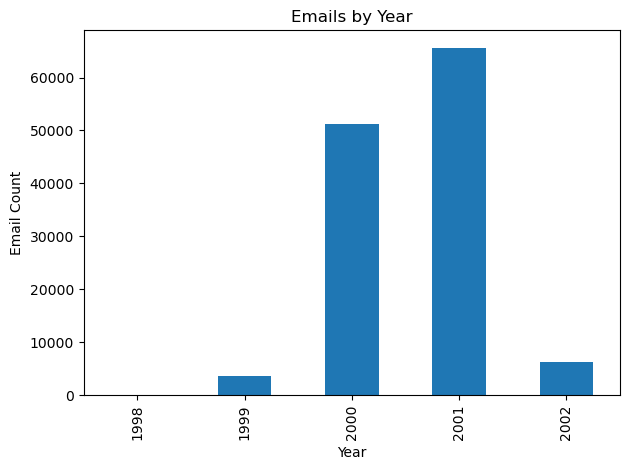

In [13]:
# Email volume by year
df_emails['year'] = df_emails['Date'].dt.year
df_emails['year'].value_counts().sort_index().plot(kind='bar', title="Emails by Year")

plt.xlabel("Year")
plt.ylabel("Email Count")
plt.tight_layout()
plt.show()

### Top senders / recipients

In [14]:
# Who sent the most emails?
df_emails['Name-From'].value_counts().head(10)

Name-From
Kay Mann            8926
Vince J Kaminski    8585
Jeff Dasovich       5363
Chris Germany       5126
Sara Shackleton     4360
Tana Jones          4123
Eric Bass           3030
Matthew Lenhart     2758
Kate Symes          2649
Sally Beck          2518
Name: count, dtype: int64

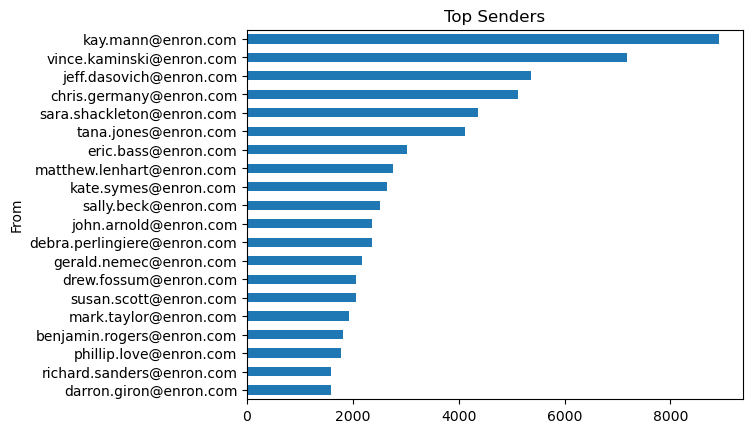

In [15]:
df_emails['From'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh', title="Top Senders")
plt.show()

Kay Mann: Legal Specialist / Counsel (Sent LOTS of compliance emails & reviews)

Vince J Kaminski: Managing Director, Research (Power user, assigned/reporting tasks frequently)

Tana Jones: Legal Specialist (Often forwarding legal docs or coordinating reviews)

Sara Shackleton: Assistant General Counsel (Trading) (Involved in contracts + regulatory stuff)

Jeff Dasovich: Director, Government Affairs (Many emails to/from PR, legal, exec teams)

Chris Germany: Legal team / Contract management (Often assigned operational/legal tasks)

Steven J Kean: EVP and Chief of Staff (Exec-level communication (HR, strategy))

Kate Symes: Power Analyst (More operations-focused communication)

These are primarily:
	•	Legal
	•	Risk
	•	Operations
	•	Mid-level and senior staff

In [16]:
# Most common recipients
df_emails['Name-To'].dropna().value_counts().head(10)

Name-To
vkaminski            2146
Suzanne Adams         978
Shirley Crenshaw      686
'vkaminski            519
Gabriel Monroy        472
Evelyn Metoyer        464
Kathleen Carnahan     447
Kerri Thompson        440
Ina Rangel            394
Carlos Sole           342
Name: count, dtype: int64

<Axes: title={'center': 'Top Recipients'}, ylabel='To'>

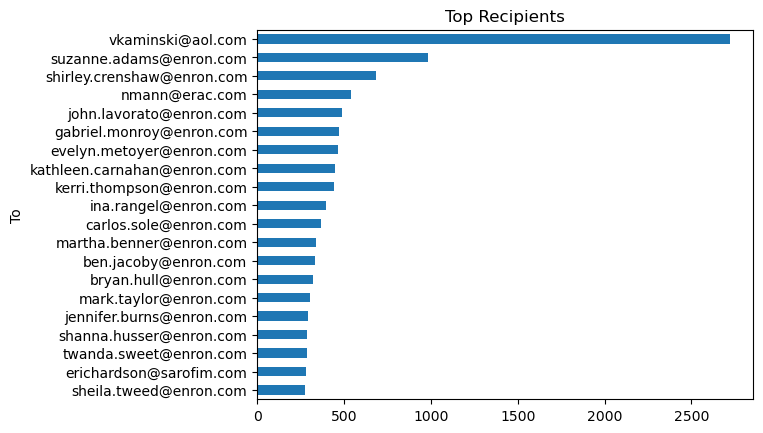

In [17]:
df_emails['To'].value_counts().head(20).sort_values().plot(kind='barh', title="Top Recipients")

Most recipients are:
	•	Legal recipients
	•	Assistants
	•	Operations leads
	•	Top executives

In [18]:
# Subject keyword frequencies
df_emails['Subject'].value_counts().head(15)

Subject
                    7109
Re:                 3082
RE:                 2949
FW:                  418
Hey                  111
Re: apb checkout     102
VAR                   98
Re: (no subject)      96
Re: Lunch             94
RE: Hello             83
Re: Hi                83
Btu Weekly            81
Re: apb               72
Congratulations       72
Re: Vacation          70
Name: count, dtype: int64

In [19]:
# Check folder names
df_emails['X-Folder'].value_counts().head(20)

X-Folder
\Kay_Mann_June2001_3\Notes Folders\Sent                   4440
\Kay_Mann_June2001_4\Notes Folders\'sent mail             4220
\Tanya_Jones_Dec2000\Notes Folders\Sent                   2633
\Vincent_Kaminski_Jun2001_4\Notes Folders\'sent mail      2574
\Sara_Shackleton_Dec2000_June2001_1\Notes Folders\Sent    2573
\Vincent_Kaminski_Jun2001_3\Notes Folders\Sent            2573
\Jeff_Dasovich_June2001\Notes Folders\Sent                2082
\Chris_Germany_Dec2000\Notes Folders\Sent                 1607
\Chris_Germany_Dec2000\Notes Folders\'sent mail           1551
\Mark_Taylor _Dec_2000\Notes Folders\Sent                 1541
\Jeff_Dasovich_Dec2000\Notes Folders\Sent                 1356
\kate symes 6-27-02\Notes Folders\Sent                    1326
\kate symes 6-27-02\Notes Folders\'sent mail              1323
\Richard_Sanders_Oct2001\Notes Folders\Sent               1214
\Sara_Shackleton_Dec2000_June2001_2\Notes Folders\Sent    1201
\Tanya_Jones_June2001\Notes Folders\Sent      

# Text Pre-Processing

In [20]:
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import nltk

# Ensure resource availability
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
custom_stopwords = {
    'ect', 'cc', 'subject', 'fw', 'mailto', 'fax', 'phone',
    'enron', 're:', 'fwd', 'codesite', 'crawler', 'one', 'eol', 
}
stop.update(custom_stopwords)

# Additional filtering rules
def is_clean_token(token):
    token = token.lower()
    if not token.isalpha(): 
        return False
    if len(token) < 3 or len(token) > 20: 
        return False
    if token in stop:
        return False
    return True

# Improved main processing function
def pre_processing_by_nltk(doc, lemmatize=True, need_sent=False):
    if not isinstance(doc, str):
        return []

    sentences = sent_tokenize(doc)
    results = []

    for sent in sentences:
        words = word_tokenize(sent)

        if lemmatize:
            words = [lemmatizer.lemmatize(w) for w in words]

        filtered = [w.lower() for w in words if is_clean_token(w)]

        if need_sent:
            results.append(filtered)
        else:
            results += filtered

    return results

In [22]:
# Apply to 'content'
df_emails['custom_content'] = df_emails['content'].fillna('').apply(pre_processing_by_nltk)
df_emails['custom_clean_content'] = df_emails['custom_content'].apply(lambda x: ' '.join(x))

# Apply to 'subject'
df_emails['custom_subject'] = df_emails['Subject'].fillna('').apply(pre_processing_by_nltk)
df_emails['custom_clean_subject'] = df_emails['custom_subject'].apply(lambda x: ' '.join(x))

In [23]:
# !pip install wordcloud

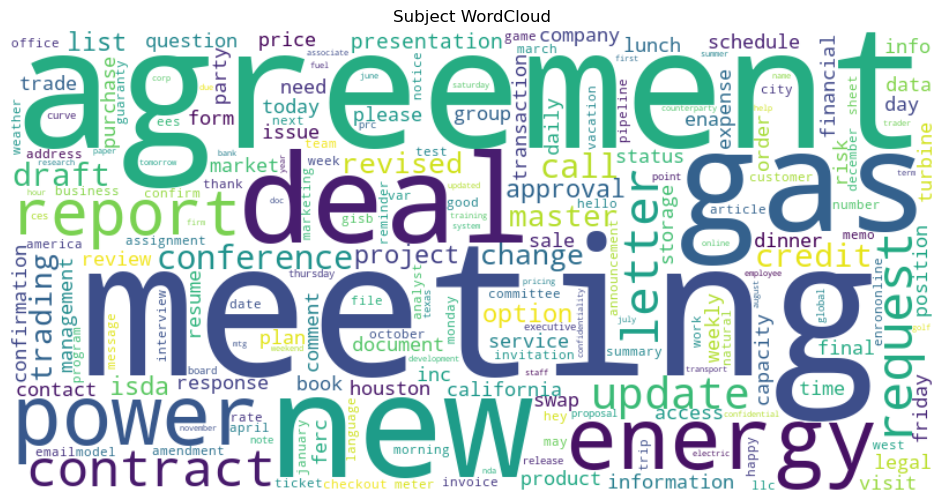

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df_emails['custom_clean_subject'].fillna('').astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Subject WordCloud")
plt.show()

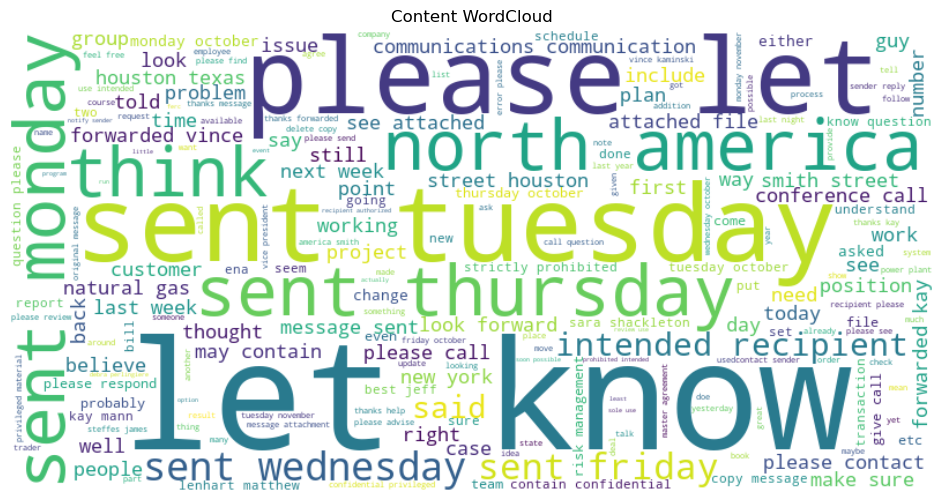

In [25]:
text = ' '.join(df_emails['custom_clean_content'].fillna('').astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Content WordCloud")
plt.show()

In [26]:
df_emails = df_emails.drop(columns=['custom_content', 'custom_subject'])

df_emails.head()  

,file,Message-ID,Date,From,To,Subject,X-Folder,X-Origin,X-FileName,content,Name-From,Name-To,Name-cc,Name-bcc,month,year,custom_clean_content,custom_clean_subject
119,maildir/blair-l/presentations/8.,<7209418.1075859337850.JavaMail.evans@thyme>,2001-11-06 21:21:25,shelley.corman@enron.com,"ava.garcia@enron.com, lynn.blair@enron.com, je...",Draft Transwestern Presentation,"\Lynn_Blair_Jan2002\Blair, Lynn\Presentations",Blair-L,lblair (Non-Privileged).pst,Attached is a draft version of my welcome and ...,Shelley Corman,Ava Garcia,Debbie Moore,,2001-11,2001,attached draft version welcome customer commun...,draft transwestern presentation
120,maildir/blair-l/presentations/3.,<596013.1075853023478.JavaMail.evans@thyme>,2001-08-23 11:01:57,john.buchanan@enron.com,lynn.blair@enron.com,NNG Winter Ops. presentation,"\LBLAIR (Non-Privileged)\Blair, Lynn\Presentat...",Blair-L,LBLAIR (Non-Privileged).pst,"Lynn, This revised presentation has Larry Berg...",John Buchanan,Lynn Blair,,,2001-08,2001,lynn revised presentation larry berger flowing...,nng winter ops presentation
121,maildir/blair-l/presentations/4.,<27726112.1075859337759.JavaMail.evans@thyme>,2001-10-25 17:39:42,shelley.corman@enron.com,"sheila.nacey@enron.com, lynn.blair@enron.com, ...",customerserv 10-25.ppt,"\Lynn_Blair_Jan2002\Blair, Lynn\Presentations",Blair-L,lblair (Non-Privileged).pst,Revised presentation for the meeting this afte...,Shelley Corman,Sheila Nacey,,,2001-10,2001,revised presentation meeting afternoon,customerserv
122,maildir/blair-l/presentations/6.,<27703086.1075859337804.JavaMail.evans@thyme>,2001-11-07 19:59:06,lynn.blair@enron.com,shelley.corman@enron.com,TW Shipper Imbalance Presentation,"\Lynn_Blair_Jan2002\Blair, Lynn\Presentations",Blair-L,lblair (Non-Privileged).pst,"Shelley, I would appreciate any comments or fe...",Lynn Blair,Shelley Corman,Lynn Blair,,2001-11,2001,shelley would appreciate comment feedback atta...,shipper imbalance presentation
123,maildir/blair-l/presentations/7.,<4484468.1075859337827.JavaMail.evans@thyme>,2001-11-07 13:57:22,bradley.holmes@enron.com,debbie.moore@enron.com,Final review,"\Lynn_Blair_Jan2002\Blair, Lynn\Presentations",Blair-L,lblair (Non-Privileged).pst,"Debbie, I'm going through some final reviews. ...",Bradley Holmes,Debbie Moore,Lynn Blair,,2001-11,2001,debbie going final review however since mornin...,final review


In [27]:
df_emails.shape

(126881, 18)

In [28]:
df_emails[df_emails['From'] == "vince.kaminski@enron.com"].groupby("To").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,To,count
748,vkaminski@aol.com,2192
640,shirley.crenshaw@enron.com,602
666,stinson.gibner@enron.com,189
661,steven.leppard@enron.com,92
488,mike.roberts@enron.com,81
499,molly.magee@enron.com,71
728,vasant.shanbhogue@enron.com,62
31,anita.dupont@enron.com,61
765,william.smith@enron.com,61
385,kevin.moore@enron.com,55


In [29]:
df_emails[(df_emails['From'] == "vince.kaminski@enron.com") & (df_emails['To'] == "shirley.crenshaw@enron.com")]

,file,Message-ID,Date,From,To,Subject,X-Folder,X-Origin,X-FileName,content,Name-From,Name-To,Name-cc,Name-bcc,month,year,custom_clean_content,custom_clean_subject
307829,maildir/kaminski-v/sent/1443.,<1068413.1075856470788.JavaMail.evans@thyme>,2000-11-21 09:03:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,"20th Annual CERAWeek - ""Shooting the Rapids: S...",\Vincent_Kaminski_Jun2001_3\Notes Folders\Sent,Kaminski-V,vkamins.nsf,"Shirley, Please, register me for this conferen...",Vince J Kaminski,Shirley Crenshaw,,,2000-11,2000,shirley please register conference vince forwa...,annual ceraweek shooting rapids strategies ris...
307834,maildir/kaminski-v/sent/3928.,<11846486.1075856927783.JavaMail.evans@thyme>,2000-05-30 09:18:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,Meeting,\Vincent_Kaminski_Jun2001_8\Notes Folders\Sent,Kaminski-V,vkamins.nsf,YI Vince ---------------------- Forwarded by V...,Vince J Kaminski,Shirley Crenshaw,,,2000-05,2000,vince forwarded vince betty coneway vince jose...,meeting
307835,maildir/kaminski-v/sent/2341.,<20441774.1075856492656.JavaMail.evans@thyme>,2000-07-26 08:18:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,My Bullet Points for Offsite,\Vincent_Kaminski_Jun2001_3\Notes Folders\Sent,Kaminski-V,vkamins.nsf,---------------------- Forwarded by Vince J Ka...,Vince J Kaminski,Shirley Crenshaw,,,2000-07,2000,forwarded vince vasant shanbhogue vince bullet...,bullet points offsite
307848,maildir/kaminski-v/sent/1778.,<23746711.1075856478761.JavaMail.evans@thyme>,2000-10-13 11:18:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,"Visit by Enron, 19 October 2000",\Vincent_Kaminski_Jun2001_3\Notes Folders\Sent,Kaminski-V,vkamins.nsf,---------------------- Forwarded by Vince J Ka...,Vince J Kaminski,Shirley Crenshaw,vkaminski,,2000-10,2000,forwarded vince piazze thomas piazzet amit raf...,visit october
307859,maildir/kaminski-v/sent/2276.,<6688060.1075856491060.JavaMail.evans@thyme>,2000-07-31 15:19:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,SAS,\Vincent_Kaminski_Jun2001_3\Notes Folders\Sent,Kaminski-V,vkamins.nsf,"Shirley, Do you remember about Exceed? Vince -...",Vince J Kaminski,Shirley Crenshaw,Vince J Kaminski,,2000-07,2000,shirley remember exceed vince forwarded vince ...,sas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319818,maildir/kaminski-v/_sent_mail/1122.,<19479941.1075856529439.JavaMail.evans@thyme>,2000-12-29 11:40:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,,\Vincent_Kaminski_Jun2001_4\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,"SHirley, Please, renew it. Vince -------------...",Vince J Kaminski,Shirley Crenshaw,,,2000-12,2000,shirley please renew vince forwarded vince nor...,
319824,maildir/kaminski-v/_sent_mail/4157.,<1681334.1075856991287.JavaMail.evans@thyme>,2000-04-18 09:58:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,Video Conference with Ross McIntyre,\Vincent_Kaminski_Jun2001_8\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,FYI Vince ---------------------- Forwarded by ...,Vince J Kaminski,Shirley Crenshaw,,,2000-04,2000,fyi vince forwarded vince capital trade resour...,video conference ross mcintyre
319830,maildir/kaminski-v/_sent_mail/4427.,<21949626.1075856998795.JavaMail.evans@thyme>,2000-02-28 08:31:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,"Altos, Pipeline Modeling Demo",\Vincent_Kaminski_Jun2001_8\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,"Shirley, Pleae, invite Clayton. Vince --------...",Vince J Kaminski,Shirley Crenshaw,,,2000-02,2000,shirley pleae invite clayton vince forwarded v...,altos pipeline modeling demo
319831,maildir/kaminski-v/_sent_mail/2288.,<29326208.1075856557573.JavaMail.evans@thyme>,2000-07-31 11:19:00,vince.kaminski@enron.com,shirley.crenshaw@enron.com,Reminder,\Vincent_Kaminski_Jun2001_4\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,"Shirley, Please, send it to the entire group. ...",Vince J Kaminski,Shirley Crenshaw,,,2000-07,2000,shirley plea

In [30]:
df_emails[df_emails['From'] == "shirley.crenshaw@enron.com"]

,file,Message-ID,Date,From,To,Subject,X-Folder,X-Origin,X-FileName,content,Name-From,Name-To,Name-cc,Name-bcc,month,year,custom_clean_content,custom_clean_subject
298712,maildir/kaminski-v/presentations/25.,<7407618.1075857061403.JavaMail.evans@thyme>,2000-04-21 09:39:00,shirley.crenshaw@enron.com,vince.kaminski@enron.com,Maureen's Presentation,\Vincent_Kaminski_Jun2001_9\Notes Folders\Pres...,Kaminski-V,vkamins.nsf,Here it is!,Shirley Crenshaw,Vince J Kaminski,,,2000-04,2000,,maureen presentation


In [31]:
df_emails[df_emails['From'] == "kay.mann@enron.com"].groupby("To").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,To,count
860,suzanne.adams@enron.com,851
616,nmann@erac.com,540
435,kathleen.carnahan@enron.com,447
104,carlos.sole@enron.com,366
41,ben.jacoby@enron.com,298
795,sheila.tweed@enron.com,247
126,ccampbell@kslaw.com,191
680,reagan.rorschach@enron.com,170
382,jkeffer@kslaw.com,168
663,pthompson@akllp.com,159


In [32]:
df_emails[df_emails['From'] == "suzanne.adams@enron.com"]

,file,Message-ID,Date,From,To,Subject,X-Folder,X-Origin,X-FileName,content,Name-From,Name-To,Name-cc,Name-bcc,month,year,custom_clean_content,custom_clean_subject
323197,maildir/hodge-j/sent_items/24.,<14215775.1075852742068.JavaMail.evans@thyme>,2001-10-19 19:55:13,suzanne.adams@enron.com,suzanne.adams@enron.com,"FW: ERIC MERTEN FROM PORTLAND OFC, SHEILA'S GR...","\JHODGE (Non-Privileged)\Hodge, Jeffrey T.\Sen...",Hodge-J,JHODGE (Non-Privileged).pst,Suzanne: This is already on my calendar so I a...,Suzanne Adams,Suzanne Adams,,,2001-10,2001,suzanne already calendar responding invitation...,eric merten portland ofc sheila group meet hod...
467436,maildir/stclair-c/important_e_mails/8.,<32536361.1075842202418.JavaMail.evans@thyme>,2001-05-14 12:22:00,suzanne.adams@enron.com,carol.clair@enron.com,Re: Resume,\Carol_StClair_June2001\Notes Folders\Importan...,STCLAIR-C,cstclai.nsf,Thanks! Carol St Clair 05/14/2001 12:20 PM To:...,Suzanne Adams,Carol St Clair,,,2001-05,2001,thanks carol clair suzanne resume suzanne send...,resume


In [33]:
df_emails[df_emails['From'] == "jeff.dasovich@enron.com"].groupby("To").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,To,count
954,nancy.sellers@robertmondavi.com,185
642,joseph.alamo@enron.com,155
984,paul.kaufman@enron.com,148
663,karen.denne@enron.com,144
1453,susan.mara@enron.com,137
163,cameron@perfect.com,115
477,james.steffes@enron.com,112
1073,richard.shapiro@enron.com,88
40,9069876@skytel.com,80
854,mday@gmssr.com,62


In [34]:
df_emails[df_emails['From'] == "chris.germany@enron.com"].groupby("To").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,To,count
413,ingrid.immer@williams.com,195
1011,trogg522@aol.com,137
473,jim.homco@enron.com,129
903,scott.goodell@enron.com,125
546,joni.veselack@neg.pge.com,95
111,brenda.fletcher@enron.com,90
746,mgermany@ch2m.com,88
672,marde.driscoll@enron.com,84
580,"katherine.kelly@enron.com, victor.lamadrid@enr...",70
377,germanj@basf-corp.com,69


In [35]:
df_emails[df_emails['To'] == "vkaminski@aol.com"].groupby("From").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,From,count
2,vince.kaminski@enron.com,2192
0,j.kaminski@enron.com,440
1,kaminski@enron.com,87


In [36]:
df_emails[df_emails['To'] == "ingrid.immer@williams.com"].groupby("From").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,From,count
0,chris.germany@enron.com,195
1,scott.neal@enron.com,2


In [37]:
df_emails[df_emails['To'] == "nancy.sellers@robertmondavi.com"].groupby("From").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,From,count
0,jeff.dasovich@enron.com,185


In [38]:
df_emails[df_emails['To'] == "nancy.sellers@robertmondavi.com"]

,file,Message-ID,Date,From,To,Subject,X-Folder,X-Origin,X-FileName,content,Name-From,Name-To,Name-cc,Name-bcc,month,year,custom_clean_content,custom_clean_subject
98477,maildir/dasovich-j/sent/318.,<6577571.1075843191731.JavaMail.evans@thyme>,2000-09-18 12:38:00,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,Re:,\Jeff_Dasovich_Dec2000\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf,"1) In Nancy's absence, I'd thought I'd keep th...",Jeff Dasovich,Nancy Sellers,"""'Eldon Sellers'""",,2000-09,2000,nancy absence thought keep alive john waters n...,
98501,maildir/dasovich-j/sent/1334.,<21009488.1075843216662.JavaMail.evans@thyme>,2000-12-12 15:32:00,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,Re: The bums,\Jeff_Dasovich_Dec2000\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf,"But if they kept Grace, they might have a winn...",Jeff Dasovich,Nancy Sellers,Cameron,,2000-12,2000,kept grace might winning season lord know nobo...,bum
98561,maildir/dasovich-j/sent/4758.,<28552597.1075843896062.JavaMail.evans@thyme>,2001-05-29 16:07:00,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,RE:,\Jeff_Dasovich_June2001\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf,"You need to worry less about Cameron, because ...",Jeff Dasovich,Nancy Sellers,,,2001-05,2001,need worry cameron think deeply rooted thing t...,
98608,maildir/dasovich-j/sent/3176.,<5058892.1075843848812.JavaMail.evans@thyme>,2001-02-12 12:03:00,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,,\Jeff_Dasovich_June2001\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf,"Great to see you guys, and despite all the exc...",Jeff Dasovich,Nancy.Sellers,,,2001-02,2001,great see guy despite excitement alot fun hope...,
98652,maildir/dasovich-j/sent/2772.,<18402213.1075843836869.JavaMail.evans@thyme>,2000-12-28 18:58:00,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,Re: FW: Presidential Advice (BS),\Jeff_Dasovich_June2001\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf,"ah jeez, i guess this means that you made it b...",Jeff Dasovich,Nancy Sellers,,,2000-12,2000,jeez guess mean made back safely,presidential advice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103778,maildir/dasovich-j/sent_items/1865.,<19442553.1075852609168.JavaMail.evans@thyme>,2001-08-31 16:17:59,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,RE: Please bring,\JDASOVIC (Non-Privileged)\Sent Items,Shankman-J,JSHANKM (Non-Privileged).pst,"will do. traffic permitting, around 7? -----Or...",Jeff Dasovich,'Nancy Sellers',,,2001-08,2001,traffic permitting around message nancy seller...,please bring
103790,maildir/dasovich-j/sent_items/2294.,<21116374.1075859204631.JavaMail.evans@thyme>,2001-11-21 16:33:08,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,,"\Jeff_Dasovich_Jan2002\Dasovich, Jeff\Sent Items",Dasovich-J,jdasovic (Non-Privileged).pst,what would you like me to bring and/or do for ...,Jeff Dasovich,Nancy Sellers (E-mail),,,2001-11,2001,would like bring friday,
103793,maildir/dasovich-j/sent_items/1926.,<8334681.1075852610908.JavaMail.evans@thyme>,2001-08-27 18:48:43,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,RE: omigod,\JDASOVIC (Non-Privileged)\Sent Items,Shankman-J,JSHANKM (Non-Privileged).pst,the secret is old vine gravensteins and a grea...,Jeff Dasovich,'Nancy Sellers',,,2001-08,2001,secret old vine gravensteins great chef thanks...,omigod
103828,maildir/dasovich-j/sent_items/2384.,<11625113.1075859206789.JavaMail.evans@thyme>,2001-12-07 00:28:15,jeff.dasovich@enron.com,nancy.sellers@robertmondavi.com,,"\Jeff_Dasovich_Jan2002\Dasovich, Jeff\Sent Items",Dasovich-J,jdasovic (Non-Privileged).pst,so you guys want to come by PC's before dinner...,Jeff Dasovich,Nancy Sellers (E-mail),,,2001-12,2001,guy want come dinner folie want meet restauran...,


In [39]:
	
df_emails[df_emails['To'] == "cameron@perfect.com"].groupby("From").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,From,count
0,jeff.dasovich@enron.com,115


# NER

In [40]:
import spacy

nlp = spacy.load("en_core_web_sm") 

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

# Rule-Based Task Labeling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
df_emails = df_emails.reset_index()

In [ ]:
# Fill all unmarked rows with 0
df_emails['is_task'] = df_emails['is_task'].fillna(0).astype(int)

df_emails.shape

(102212, 31)

In [ ]:
# Train/Validation/Test split
train_df, val_df = train_test_split(df_emails, test_size=0.2, random_state=42, stratify=df_emails['is_task'])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['is_task'])  # 80/10/10
len(train_df), len(val_df), len(test_df)

(101504, 12688, 12689)

## Tf-idf

In [ ]:
tfidf = TfidfVectorizer(
    max_features=40000,
    stop_words="english",
    ngram_range=(1, 3)  # unigrams, bigrams, trigrams
)

X_train = tfidf.fit_transform(train_df['custom_clean_content'])
X_val = tfidf.transform(val_df['custom_clean_content'])
X_test = tfidf.transform(test_df['custom_clean_content'])

y_train = train_df['is_task']
y_val = val_df['is_task']
y_test = test_df['is_task']

In [ ]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# NLP

## Logit

In [ ]:
# **4️⃣ Tune Logistic Regression (Stronger Regularization)**
param_dist_logreg = {
    "C": np.logspace(-2, 2),  # ✅ Reduce number of `C` values
    "penalty": ["l2"],  # ✅ Use only L2 regularization (L1 & ElasticNet take longer)
    "solver": ["lbfgs"],  # ✅ "lbfgs" is much faster than "saga"
}

strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

cv_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=5000, class_weight="balanced"),
    param_distributions=param_dist_logreg,
    n_iter=10,
    scoring="roc_auc_ovr",
    cv=strat_k_fold,
    verbose=3,
    n_jobs=-1,
    refit=True,
    random_state=1234
)

# **5️⃣ Train Model on Optimized Features**
cv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=5000),
                   n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.5512855...
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                                        'penalty': ['l2'],
                                        'solver': ['lbfgs']},
                   random_state=1234, scoring='roc_auc_ovr', verbose=3)

In [ ]:
cv_lr.best_params_, cv_lr.best_score_

({'solver': 'lbfgs', 'penalty': 'l2', 'C': 8.68511373751352},
 0.9325140377329924)

In [ ]:
cv_lr.predict(X_test), cv_lr.predict_proba(X_test)[:, 1].mean()  # Only class 1

(array([1, 1, 1, ..., 1, 1, 1]), 0.8258968605302434)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, cv_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.84      0.63      1115
           1       0.98      0.92      0.95     11574

    accuracy                           0.91     12689
   macro avg       0.74      0.88      0.79     12689
weighted avg       0.94      0.91      0.92     12689



In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, cv_lr.predict_proba(X_train)[:, 1]), roc_auc_score(y_val, cv_lr.predict_proba(X_val)[:, 1])

(0.9918554448579286, 0.9448208467288365)

In [ ]:
triples = []

for _, row in df_emails.iterrows():
    msg_id = row.get('Message-ID')
    entities = row.get('entities', [])
    task_text = row.get('custom_clean_subject', '').strip()
    sender = row.get('From', '').strip()

    if not task_text:
        continue  # skip blank tasks

    person = next((ent[0].strip().title() for ent in entities if ent[1] == 'PERSON'), None)
    date = next((ent[0].strip().title() for ent in entities if ent[1] == 'DATE'), None)
    org = next((ent[0].strip().title() for ent in entities if ent[1] == 'ORG'), None)

    if person:
        triples.append((person, 'assigned_task', task_text))
    if date:
        triples.append((task_text, 'due_on', date))
    if org:
        triples.append((task_text, 'about', org))
    if sender:
        triples.append((sender, 'sent', task_text))
    if msg_id:
        triples.append((task_text, 'mentioned_in', msg_id))

In [ ]:
df_triples = pd.DataFrame(triples, columns=['source', 'relationship', 'target'])
df_triples.to_csv('entities_for_neo4j.csv', index=False)

In [ ]:
df_triples['relationship'].unique()

array(['sent', 'mentioned_in'], dtype=object)

In [ ]:
df_triples['source'].unique()

array(['no.address@enron.com',
       'training houston worldwide dow jones training',
       'important announcement regarding document preservation', ...,
       'station air permits',
       'action requested past due invoice user lawrence campbell',
       'must rang'], dtype=object)

In [ ]:
df_triples['target'].unique()

array(['training houston worldwide dow jones training',
       '<31059796.1075853082632.JavaMail.evans@thyme>',
       'important announcement regarding document preservation', ...,
       '<363513.1075857932779.JavaMail.evans@thyme>',
       '<27344830.1075857891130.JavaMail.evans@thyme>',
       '<12461981.1075857890259.JavaMail.evans@thyme>'], dtype=object)

## XGBoost

In [ ]:
# from xgboost import XGBClassifier

# params = {
#     'max_depth': [5, 10, 20],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200, 500],
#     'scale_pos_weight': [1, 2, 5],  # handle class imbalance
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# xgb = XGBClassifier(
#     use_label_encoder=False,  # prevents warning
#     eval_metric='logloss',    # avoid auto-metric warning
#     random_state=1234,
#     tree_method='hist'        # faster on CPUs
# )

# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

# search = RandomizedSearchCV(
#     xgb,
#     param_distributions=params,
#     n_iter=10,
#     scoring="roc_auc_ovr",  # for multi-class, or "roc_auc" for binary
#     cv=strat_k_fold,
#     verbose=2,
#     n_jobs=-1,
#     refit=True,
#     random_state=1234
# )

# search.fit(X_train, y_train)

## LightGBM

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from lightgbm import LGBMClassifier

# params = {
#     'max_depth': [4, 6, 8],              # simpler trees
#     'n_estimators': [100, 300, 500],     # capped at 500
#     'learning_rate': [0.05, 0.1],        # avoids overfitting
#     'scale_pos_weight': [1, 3]           # helps with class imbalance
# }

# strat_k_fold = StratifiedKFold(n_splits=2, shuffle=True, random_state=1234)

# lgbm = LGBMClassifier(class_weight='balanced', random_state=1234)

# search = RandomizedSearchCV(
#     lgbm,
#     param_distributions=params,
#     n_iter=10,
#     scoring="roc_auc_ovr",
#     cv=strat_k_fold,
#     verbose=2,
#     n_jobs=-1,
#     refit=True,
#     random_state=1234
# )

# search.fit(X_train, y_train)

In [ ]:
# search.best_params_, search.best_score_